## 1. Initializations and Dataset Download

In [13]:
import sys
from pathlib import Path

# Add parent directory to path
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

In [14]:
# !pip install opendatasets --quiet
# import opendatasets as od
# od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

## 2. Imports

Lets start by getting all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with mps.

In [15]:
import torch
import torch.nn as nn
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creatning the objects
from torchsummary import summary # Visualize the model layers and number of parameters

from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu' # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print(device)

cpu


## 3. EDA

Now lets read the dataset, this lab was developed by Google Colab, so dataset downloaded and read from the path shown below. We will be reading the dataset using pandas read_csv function, then we will remove the nulls/missing data from our dataframe as a filteration process, keep in mind that this process is essential as missing data will stop the code from training. You can skip dropping the missing values if you are 100% sure that there are no missing values in your data. Also, we dropped the id column because it will not affect our classification at all. We printed the output possibilities as we can see its a binary classification. We printed also the data shape (rows, columns) After that we printed the dataset shape and we used the head() function to visualize the first 5 rows, this step is optional as it just allows us to see the first 5 rows and will not affect the training process.

In [16]:
# Read dataset
df = pd.read_csv("riceClassification.csv")
print("Dataset overview:")
display(df.head())

# Display dataset information
from utils import check_data_information
desc_df = check_data_information(df, df.columns)
print("Dataset information:")
print(f"Original data shape: {df.shape}")
display(desc_df)


Dataset overview:


,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Dataset information:
Original data shape: (18185, 12)


,Feature,Data Type,Null Values,Null Percentage,Duplicated Values,Unique Values,Unique Sample
0,id,int64,0,0.0,0,18185,"1, 2, 3, 4, 5"
1,Area,int64,0,0.0,0,5343,"4537, 2872, 3048, 3073, 3693"
2,MajorAxisLength,float64,0,0.0,0,18185,"92.2293165, 74.69188071, 76.2931638, 77.033627..."
3,MinorAxisLength,float64,0,0.0,0,18185,"64.01276874, 51.40045446, 52.04349114, 51.9284..."
4,Eccentricity,float64,0,0.0,0,18185,"0.7199162256, 0.7255527468, 0.7312109273, 0.73..."
5,ConvexArea,int64,0,0.0,0,5450,"4677, 3015, 3132, 3157, 3802"
6,EquivDiameter,float64,0,0.0,0,5343,"76.00452496, 60.47101762, 62.29634124, 62.5512..."
7,Extent,float64,0,0.0,0,18007,"0.6575362319, 0.7130089374, 0.7591531756, 0.78..."
8,Perimeter,float64,0,0.0,0,16246,"273.085, 208.317, 210.012, 210.657, 230.332"
9,Roundness,float64,0,0.0,0,18184,"0.7645096145, 0.8316582009, 0.8684335737, 0.87..."


In [17]:
# Preprocessing steps
df = df.drop(columns=["id"]) # Dropping the id column since it doesn't contain important information

In [18]:
# Checking the distribution of the target variables
df["Class"].value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

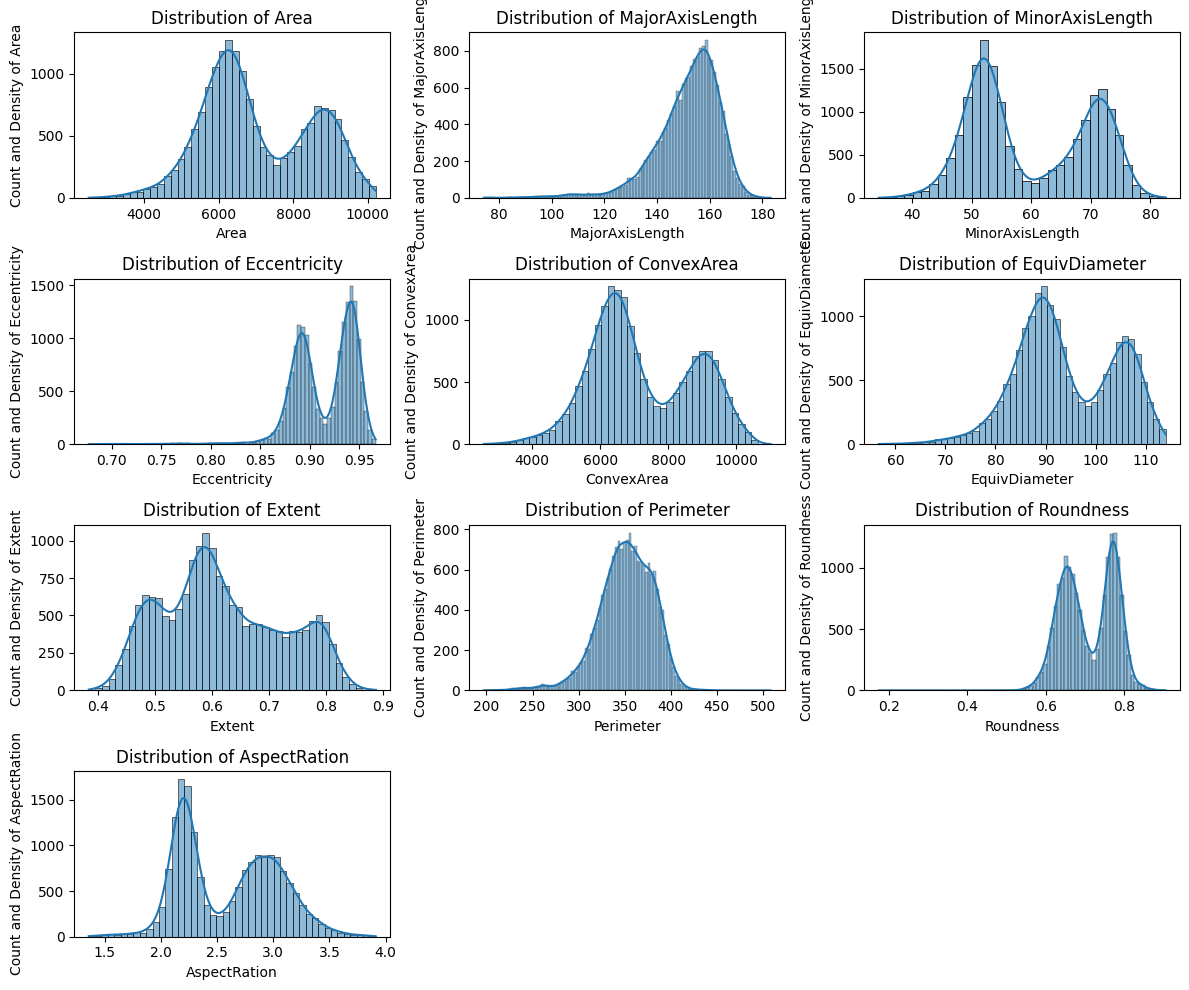

,Feature,overall_count,overall_mean,overall_std,overall_min,overall_25%,overall_50%,overall_75%,overall_max,overall_range,overall_IQR,overall_CV,overall_skewness,overall_kurtosis
0,Area,18185.0,7036.492989,1467.197150,2522.000000,5962.000000,6660.000000,8423.000000,10210.000000,7688.000000,2461.000000,20.851256,0.195594,-0.871609
1,MajorAxisLength,18185.0,151.680754,12.376402,74.133114,145.675910,153.883750,160.056214,183.211434,109.078320,14.380304,8.159507,-1.435412,3.845754
2,MinorAxisLength,18185.0,59.807851,10.061653,34.409894,51.393151,55.724288,70.156593,82.550762,48.140868,18.763442,16.823297,0.203084,-1.406644
3,Eccentricity,18185.0,0.915406,0.030575,0.676647,0.891617,0.923259,0.941372,0.966774,0.290127,0.049755,3.340061,-1.109837,3.772370
4,ConvexArea,18185.0,7225.817872,1502.006571,2579.000000,6125.000000,6843.000000,8645.000000,11008.000000,8429.000000,2520.000000,20.786665,0.202365,-0.866272
5,EquivDiameter,18185.0,94.132952,9.906250,56.666658,87.126656,92.085696,103.559146,114.016559,57.349901,16.432490,10.523680,-0.003633,-0.666257
6,Extent,18185.0,0.616653,0.104389,0.383239,0.538530,0.601194,0.695664,0.886573,0.503334,0.157135,16.928395,0.277214,-0.850320
7,Perimeter,18185.0,351.606949,29.500620,197.015000,333.990000,353.088000,373.003000,508.511000,311.496000,39.013000,8.390227,-0.655806,1.348106
8,Roundness,18185.0,0.707998,0.067310,0.174590,0.650962,0.701941,0.769280,0.904748,0.730158,0.118318,9.507107,-0.180811,-0.431796
9,AspectRation,18185.0,2.599081,0.434836,1.358128,2.208527,2.602966,2.964101,3.911845,2.553716,0.755574,16.730392,0.209437,-0.968168


In [ ]:
# Checking the distribution and statistical summary of the values
from utils import describe_numerical_combined, plot_dynamic_hisplots_kdeplots

nums_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
nums_cols.remove('Class')  # Remove target column from numerical columns

# Hisplot function implementation
plot_dynamic_hisplots_kdeplots(df=df, col_series=nums_cols, ncols=3, figsize=(12, 10))

# Display the overall statistics for numerical columns
numerical_summary = describe_numerical_combined(df, nums_cols)
display(numerical_summary)

## 4. Data Preprocessing

## 5. Data Splitting

## 6. Dataset Object

## 7. Training Hyper Parameters

## 8. Data Loaders

## 9. Model Class

## 10. Model Creation

## 11. Loss and Optimizer

## 12. Training

## 13. Testing

## 14. Plotting and Visualizations (Optional)

## 15. Inference